In [1]:
#@title Import the necessary things and confs

! pip install -Uq timm
import timm

from pathlib import Path
import os

creds = '{"username":"sebasmanco","key":"a0f01aadb0e584b9c9aa0e8ebf5a2696"}'                        # credentials for kaggle APi 

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

     |████████████████████████████████| 549 kB 10.1 MB/s 
     |████████████████████████████████| 182 kB 62.1 MB/s 


In [2]:
!ls 

sample_data


In [4]:
!cd sample_data

sample_data


In [5]:
!ls sample_data

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [2]:
from fastkaggle import *

comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')  

100%|██████████| 1.02G/1.02G [00:12<00:00, 86.4MB/s]


In [3]:
from fastai.imports import *
%config InlineBackend.figure_format = 'retina'

In [4]:
from fastai.vision.all import * 
set_seed(42)

path.ls()

(#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/test_images')]

In [5]:
trn_path = Path('sml')

In [7]:
resize_images(path/'train_images', dest=trn_path, max_size=256, recurse=True)

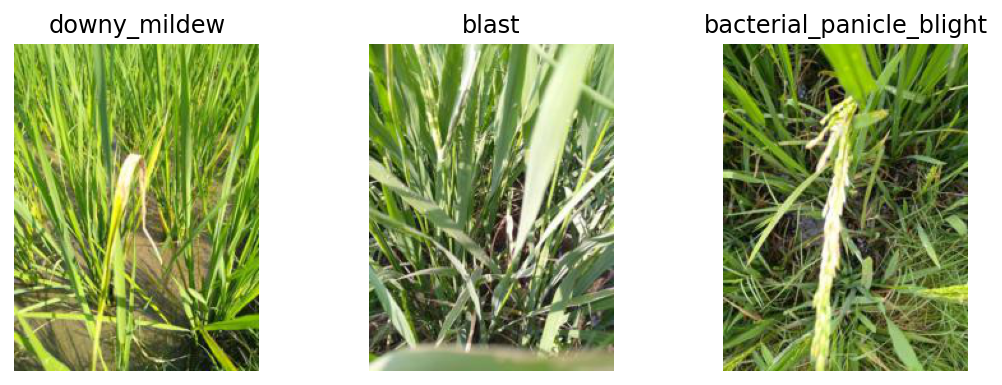

In [8]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
                                   item_tfms=Resize((256,192)))

dls.show_batch(max_n=3)

In [9]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [10]:
learn = train('resnet26d', item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.916162,1.457961,0.456031,00:32


epoch,train_loss,valid_loss,error_rate,time
0,1.299235,0.975832,0.323402,00:29
1,0.971255,0.688839,0.222009,00:30
2,0.694826,0.504231,0.155214,00:28
3,0.514977,0.403489,0.127343,00:29
4,0.436776,0.390953,0.118693,00:28


In [11]:
arch = 'convnext_small_in22k'

In [12]:
learn = train(arch, item=Resize(192, method='squish'),
              batch=aug_transforms(size=128, min_scale=0.75))

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.318420,0.884275,0.277271,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.649438,0.439884,0.130226,00:43
1,0.499517,0.358396,0.113888,00:43
2,0.317307,0.217442,0.070159,00:42
3,0.191772,0.149370,0.047573,00:43
4,0.130436,0.133076,0.042768,00:42


In [13]:
def train(arch, item, batch, epochs=5):
    # dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,item_tfms=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()

    # learn = train(arch, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),batch=aug_transforms(size=(171,128), min_scale=0.75))

    learn.fine_tune(epochs, 0.01)
    return learn

In [14]:
learn = train(arch, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),batch=aug_transforms(size=(171,128), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.118699,0.681455,0.229697,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.526475,0.348620,0.111965,01:00
1,0.395841,0.266126,0.074003,01:00
2,0.218790,0.163967,0.044690,01:00
3,0.105583,0.120016,0.033638,01:01
4,0.060360,0.103701,0.026910,01:00


In [15]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [16]:
error_rate(preds, targs)

TensorBase(0.0269)

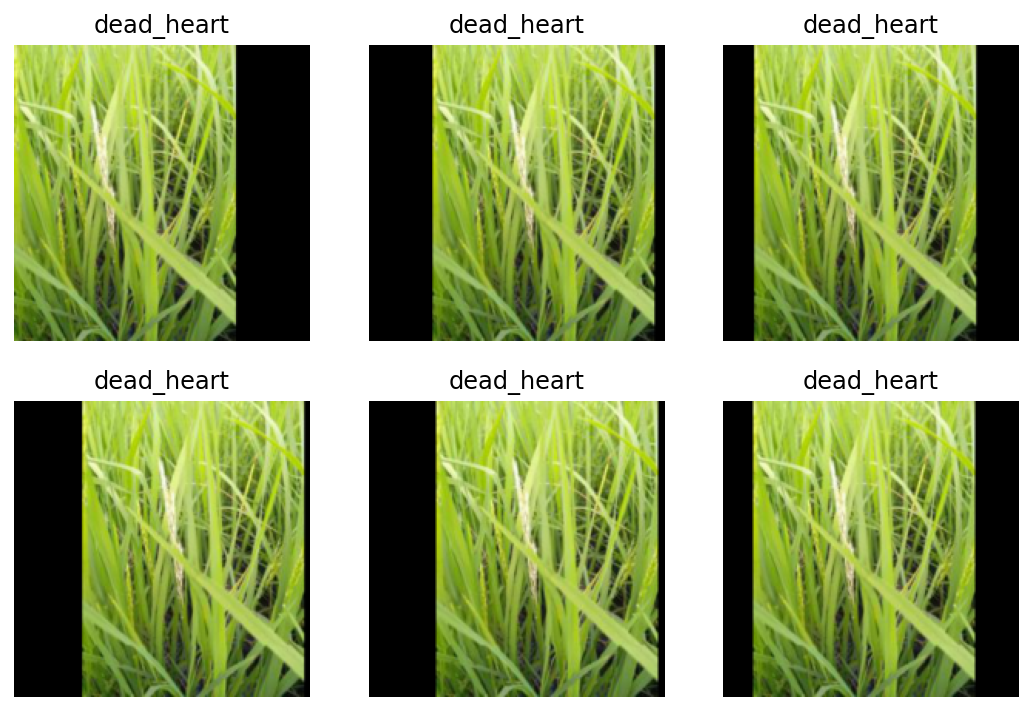

In [17]:
learn.dls.train.show_batch(max_n=6, unique=True)

In [19]:
tta_preds,_ = learn.tta(dl=valid)

In [20]:
error_rate(tta_preds, targs)

TensorBase(0.0264)

In [21]:
trn_path = path/'train_images'

In [22]:
learn = train(arch, epochs=12,
              item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(256,192), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.018865,0.543360,0.180202,01:32


epoch,train_loss,valid_loss,error_rate,time
0,0.475337,0.263101,0.088419,01:39
1,0.358675,0.283533,0.098510,01:37
2,0.323377,0.241510,0.071600,01:36
3,0.226937,0.219553,0.062470,01:36
4,0.165078,0.240682,0.059587,01:36
5,0.125430,0.200392,0.034118,01:36
6,0.090725,0.195255,0.044210,01:36
7,0.054887,0.151480,0.028832,01:35
8,0.043645,0.126713,0.022585,01:36
9,0.027114,0.120604,0.024507,01:37


In [23]:
tta_preds,targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.0192)